Missing values found! Removing or filling them...


C:\conda_tmp\ipykernel_31392\1143681064.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\ProgramData\anaconda3\envs\main_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.1427 - val_loss: 0.0142
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0082 - val_loss: 0.0042
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0

Model saved successfully!
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train MSE: 0.0016465532579492566
Test MSE: 0.0019390579709021275


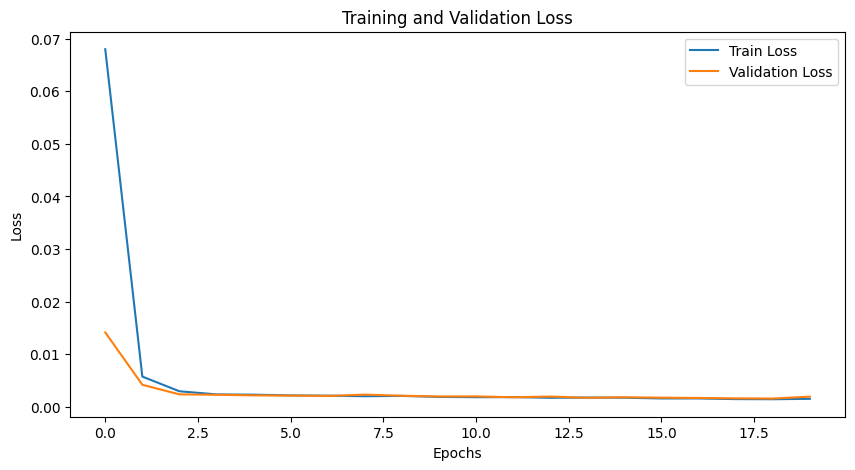

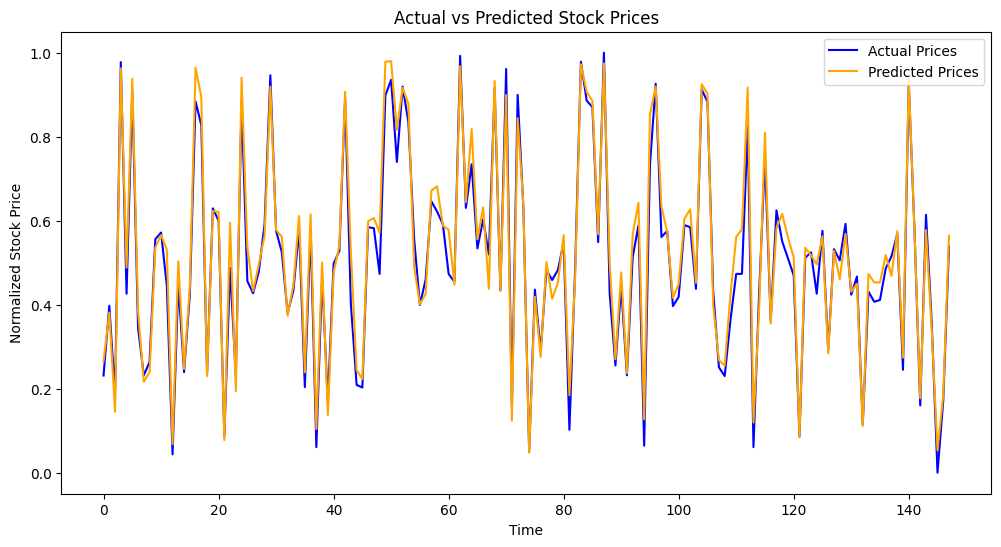

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('merged_stock_sentiment_data.csv')

# Check for missing values and remove/fill them
if data.isnull().sum().any():
    print("Missing values found! Removing or filling them...")
    # Fill forward and drop any remaining NaN values
    data.fillna(method='ffill', inplace=True)
    data.dropna(inplace=True)

# Ensure no remaining NaNs
assert not data.isnull().values.any(), "Data still contains NaN values!"

# Normalize the relevant columns
scaler = MinMaxScaler()
data[['Close', 'avg_sentiment']] = scaler.fit_transform(data[['Close', 'avg_sentiment']])

# Prepare sequences for LSTM
sequence_length = 50  # Number of previous time steps to consider
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[['Close', 'avg_sentiment']].iloc[i-sequence_length:i].values)
    y.append(data['Close'].iloc[i])

X, y = np.array(X), np.array(y)

# Ensure no NaNs in X or y
assert not np.isnan(X).any(), "Feature data (X) contains NaN values!"
assert not np.isnan(y).any(), "Target data (y) contains NaN values!"

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='tanh'),
    Dense(1)  # Output layer for predicting the stock price
])

# Compile the model with Mean Squared Error loss function
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=MeanSquaredError())

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Save the trained model
model.save('stock_sentiment_model.h5')  # Save the model as an H5 file
print("Model saved successfully!")

# Check for NaNs in predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

assert not np.isnan(train_predictions).any(), "Train predictions contain NaN values!"
assert not np.isnan(test_predictions).any(), "Test predictions contain NaN values!"

# Compute Mean Squared Error
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(test_predictions, label='Predicted Prices', color='orange')
plt.legend()
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.show()

# To load the model later, you can use:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('stock_sentiment_model.h5', custom_objects={'MeanSquaredError': MeanSquaredError})
# print("Model loaded successfully!")


In [2]:
# Save the trained model
model.save('stock_sentiment_model.h5')  # Save the model as an H5 file

print("Model saved successfully!")


Model saved successfully!


In [3]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('stock_sentiment_model.h5')

print("Model loaded successfully!")


Model loaded successfully!


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import requests
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import load_model

# Download the VADER lexicon (only needed once)
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define the stock symbol and number of days for news sentiment data
stock_symbol = 'AAPL'
num_days = 7

# Step 1: Get the latest stock data
stock_data = yf.download(stock_symbol, period='1d', interval='1d')  # Get the most recent stock data
stock_data = stock_data[['Close']]  # Use only the 'Close' price for simplicity

# Step 2: Get the latest news sentiment data
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - pd.Timedelta(days=num_days)).strftime('%Y-%m-%d')

api_key = 'f3e342dc-477b-4784-bba2-a0916569947b'  # Replace with your actual API key
base_url = 'https://content.guardianapis.com/search'

# Fetch news articles
news_data = []
current_date = pd.to_datetime(start_date)

while current_date <= pd.to_datetime(end_date):
    date_str = current_date.strftime('%Y-%m-%d')
    params = {
        'section': 'business',
        'page-size': 200,
        'from-date': date_str,
        'to-date': date_str,
        'show-fields': 'body',
        'api-key': api_key,
    }
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        results = response.json().get("response", {}).get("results", [])
        if not results:
            print(f"No results found for {date_str}")
        for article in results:
            # Check if the 'fields' and 'body' keys exist
            if "fields" in article and "body" in article["fields"]:
                news_data.append({'date': date_str, 'content': article["fields"]["body"]})
    else:
        print(f"Failed to fetch data for {date_str}: {response.status_code}")
    
    current_date += pd.Timedelta(days=1)

# Analyze sentiment
if news_data:
    news_df = pd.DataFrame(news_data)
    news_df['sentiment'] = news_df['content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    sentiment_data = news_df.groupby('date')['sentiment'].mean().reset_index()
else:
    print("No news data found.")
    sentiment_data = pd.DataFrame(columns=['date', 'sentiment'])

# Step 3: Prepare the data for prediction (latest stock price and sentiment)
if not stock_data.empty and not sentiment_data.empty:
    latest_stock_price = stock_data['Close'].values[-1]  # Most recent stock price
    latest_sentiment = sentiment_data['sentiment'].values[-1]  # Most recent sentiment score

    # Ensure that the values are scalar and not arrays
    latest_stock_price = latest_stock_price.item()  # Convert to scalar
    latest_sentiment = latest_sentiment.item()  # Convert to scalar

    # Combine stock price and sentiment into one feature array
    X = np.array([[[latest_stock_price, latest_sentiment]]])  # Reshape to (1, 1, 2)

    # Step 4: Load the pre-trained model
    model = load_model('stock_sentiment_model.h5', custom_objects={'MeanSquaredError': tf.keras.losses.MeanSquaredError})

    # Step 5: Predict the stock price for the next day using the loaded model
    predicted_price_normalized = model.predict(X)  # Make the prediction

    # Step 6: Denormalize the predicted price back to the actual price
    # Assuming you have the scaler used during training to normalize the data
    # In this case, we just use the stock price scaler to revert the prediction
    predicted_price_actual = predicted_price_normalized[0][0] * (stock_data['Close'].max() - stock_data['Close'].min()) + stock_data['Close'].min()

    # Output the predicted stock price for the next day
    print(f"Predicted stock price for {stock_symbol} for the next day: ${predicted_price_actual.item():.2f}")

else:
    print("Error: Stock or sentiment data is missing!")


[nltk_data] Downloading package vader_lexicon to C:\Users\RUTHVIK
[nltk_data]     REDDY\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Predicted stock price for AAPL for the next day: $239.65
